In [27]:
import requests
from PIL import Image, ImageFont, ImageDraw
import torch
import cv2
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import evaluate
import os
import xml.etree.ElementTree as ET
import json
from random import shuffle
import random
from rembg import remove
from transformers import OwlViTProcessor, OwlViTForObjectDetection, AutoProcessor
import itertools
import concurrent.futures

In [28]:
# settings
annotations_folder_path = "../../../Data/Annotations/"
images_folder_path = "../../../Data/shells/"
fixed_images_path = "../../../Data/Fixed_support/"

examples_path = "../../../Tex/fig/chapter3/shell_examples/"

# Defining some classes and values

In [29]:
NO_MATCH = 0
NAME_DOES_NOT_MATCH = 1
CORRECT = 2

class Annotation:
    def __init__(self, *, filename = "", width = 0, height = 0, x = 0, y = 0, name = "") -> None:
        self.filename = filename
        self.boxwidth = width
        self.boxheight = height
        self.x = x
        self.y = y
        self.name = name
    
    def IoU(self, x, y, w, h):
        x1 = max(self.x, x)
        y1 = max(self.y, y)
        x2 = min(self.x + self.boxwidth, x + w)
        y2 = min(self.y + self.boxheight, y + h)
        intersection = max(0, x2 - x1) * max(0, y2 - y1)
        union = self.boxwidth * self.boxheight + w * h - intersection
        return intersection / union
    
    def compare(self, x, y, w, h, name, iou_threshold=0.5) -> int:
        if self.IoU(x, y, w, h) < iou_threshold:
            return NO_MATCH
        if self.name != name:
            return NAME_DOES_NOT_MATCH
        return CORRECT
    
    __repr__ = __str__ = lambda self: f"{self.filename} {self.boxwidth} {self.boxheight} {self.x} {self.y} {self.name}"

class AnnotatedImage:
    def __init__(self, *, img_dir = "", filename = "", annotations = []) -> None:
        self.filename = filename
        self.image = Image.open(os.path.join(img_dir, filename))
        self.annotations:list[Annotation] = annotations
    
    @property
    def width(self) -> int:
        return self.image.width
    
    @property
    def height(self) -> int:
        return self.image.height
    
    @staticmethod
    def from_xml(xml_file:str, img_dir = "") -> 'AnnotatedImage':
        tree = ET.parse(xml_file)
        root = tree.getroot()
        filename = root.find('filename').text
        annotations = []
        for obj in root.findall('object'):
            name = obj.find('name').text
            x = int(obj.find('bndbox').find('xmin').text)
            y = int(obj.find('bndbox').find('ymin').text)
            boxwidth = int(obj.find('bndbox').find('xmax').text) - x
            boxheight = int(obj.find('bndbox').find('ymax').text) - y
            annotations.append(Annotation(filename = filename, width = boxwidth, height = boxheight, x = x, y = y, name = name))
        return AnnotatedImage(filename = filename, img_dir = img_dir, annotations = annotations)
    
    def get_object_image_cutout(self, annotation:Annotation) -> Image.Image:
        return self.image.crop((annotation.x, annotation.y, annotation.x + annotation.boxwidth, annotation.y + annotation.boxheight))
    
    @property
    def annotation_classes(self) -> list[str]:
        return [annotation.name for annotation in self.annotations]
    
    @property
    def object_image_cutouts(self) -> list[Image.Image]:
        return [self.get_object_image_cutout(annotation) for annotation in self.annotations]
    
    @property
    def objects(self) -> list[str, Image.Image]:
        return zip(self.annotation_classes, self.object_image_cutouts)
    
    __str__ = lambda self: f"{self.filename} {self.width} {self.height} {self.annotations}"
    
    def check_annotation(self, annotation:Annotation) -> bool:
        return annotation in self.annotations
    
    def check_bbox(self, x, y, w, h, name) -> tuple[int, Annotation]:
        results = []
        for annotation in self.annotations:
            results.append((annotation.compare(x, y, w, h, name), annotation))
        values = [result[0] for result in results]
        max_value = max(values)
        max_value_index = values.index(max_value)
        return max_value, results[max_value_index][1]
    
    
USE_TEXT = 0
USE_RANDOM_IMAGE = 1
USE_PICKED_IMAGE = 2

# loading the dataset

In [30]:
dir, dirs, files = next(os.walk(annotations_folder_path))

annotated_images:list[AnnotatedImage] = []

for file in files:
    annotated_images.append(AnnotatedImage.from_xml(annotations_folder_path + file, images_folder_path))

#find the largest bounding box in the dataset 
max_width = 0
max_height = 0
for annotated_image in annotated_images:
    for annotation in annotated_image.annotations:
        if annotation.boxwidth * annotation.boxheight > max_width * max_height:
            max_width = annotation.boxwidth
            max_height = annotation.boxheight
            
print(max_width, max_height, max_width * max_height)

2780 1807 5023460


## Dataset statistics

annotations: {
    "Baltic tellin": 69,
    "Cockle": 89,
    "Thick trough shell": 91,
    "Mussel": 268,
    "Banded wedge shell": 32,
    "Elliptical trough shell": 18,
    "Cut trough shell": 36,
    "Oyster": 9,
    "Jackknife": 2
}
Total images: 96
Total annotations: 614
Total images: 302
Total un-annotated images: 206
[27872, 30444, 31304, 34320, 35175, 35905, 38804, 39130, 39501, 39775, 40600, 41925, 43240, 43780, 45024, 45264, 45901, 46315, 46795, 50232, 54516, 55000, 56430, 56964, 57566, 59598, 60753, 62244, 63832, 63948, 64965, 66389, 67797, 67800, 67854, 68272, 69560, 69936, 70272, 71441, 72452, 72772, 74635, 74740, 75472, 77400, 77720, 77843, 77910, 78030, 78108, 78616, 78765, 78948, 79460, 79534, 80073, 80586, 82650, 82663, 84280, 84364, 86460, 86584, 87579, 87750, 87912, 89040, 89376, 93532, 94428, 94752, 95718, 96280, 96570, 96824, 97526, 99400, 99550, 100536, 100540, 101210, 101518, 101518, 101654, 102074, 102660, 103020, 103212, 103734, 103740, 103944, 104110, 104646,

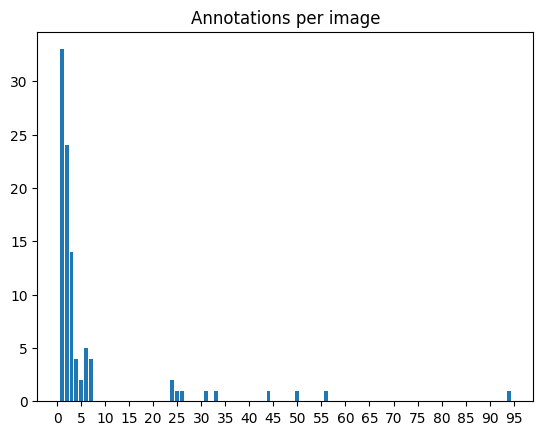

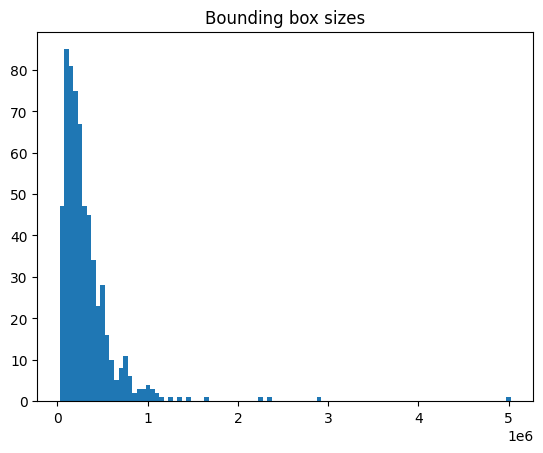

In [31]:
classes_count = {}
for img in annotated_images:
    for annotation in img.annotations:
        if annotation.name in classes_count:
            classes_count[annotation.name] += 1
        else:
            classes_count[annotation.name] = 1
            
print("annotations:", json.dumps(classes_count, indent=4))

print(f"Total images: {len(annotated_images)}")
print(f"Total annotations: {sum(classes_count.values())}")

# find the total un-anotated images
dir, dirs, files = next(os.walk(images_folder_path))
print(f"Total images: {len(files)}")
print(f"Total un-annotated images: {len(files) - len(annotated_images)}")

annotations_per_image_count = {}
for img in annotated_images:
    if len(img.annotations) in annotations_per_image_count:
        annotations_per_image_count[len(img.annotations)] += 1
    else:
        annotations_per_image_count[len(img.annotations)] = 1
# sort the dictionary by key
annotations_per_image_count = dict(sorted(annotations_per_image_count.items()))

# draw a graph of the annotations per image with as title "Annotations per image"
plt.bar(annotations_per_image_count.keys(), annotations_per_image_count.values())
plt.title("Annotations per image")
#more lines on the x-axis
plt.xticks(np.arange(0, max(annotations_per_image_count.keys()) + 5, 5.0))

# draw a bell curve of the size of the bounding boxes
# first get the sizes of the bounding boxes
sizes = []
for img in annotated_images:
    for annotation in img.annotations:
        sizes.append(annotation.boxwidth * annotation.boxheight)
# sort the sizes
sizes.sort()
print(sizes)
# average and median size
print(f"Average size: {sum(sizes) / len(sizes)}")
print(f"Average compare to total image size: {((sum(sizes) / len(sizes)) / (img.width * img.height))*100}%")
print(f"Median size: {sizes[len(sizes) // 2]}")
# draw the bell curve
plt.figure()
plt.hist(sizes, bins=100)
plt.title("Bounding box sizes")


# write 9 examples of images with annotations to a file (1.jpg => 9.jpg)
img_indexes = [1,5,20,54,92,52,15,65,75]
for i in range(9):
    annotated_image = annotated_images[img_indexes[i]]
    img = annotated_image.image.copy()
    draw = ImageDraw.Draw(img)
    for annotation in annotated_image.annotations:
        draw.rectangle((annotation.x, annotation.y, annotation.x + annotation.boxwidth, annotation.y + annotation.boxheight), outline="red", width=30)
    draw.text((10, 10), annotated_image.filename, fill="red", font=ImageFont.truetype("arial.ttf", 150))
    # resize the image by 10 times
    img = img.resize((int(img.width / 10), int(img.height / 10)))
    img.save(examples_path + str(i + 1) + ".jpg")

## Preparing the model

In [32]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")
    
processor:OwlViTProcessor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")

Using GPU


## Data loading

In [33]:
# mode = USE_TEXT
mode = USE_RANDOM_IMAGE
# mode = USE_PICKED_IMAGE

remove_bg = False

#clone all img into test list
query_images = annotated_images.copy()

if mode == USE_TEXT:
    raise NotImplementedError("I should implement this")

elif mode == USE_RANDOM_IMAGE:
    # find an image for each class and extract it
    support_images = set()
    support_images_cutouts = {}
    shuffle(annotated_images)
    for class_name in classes_count:
        for img in annotated_images:
            for annotation in img.annotations:
                if annotation.name == class_name:
                    support_images_cutouts[class_name] = img.get_object_image_cutout(annotation)
                    support_images.add(img)
                    break
            if class_name in support_images_cutouts:
                break

    for img in support_images:
        query_images.remove(img)
        
elif mode == USE_PICKED_IMAGE:
    support_images_cutouts = {}
    imgs = list(os.walk(fixed_images_path + "base"))[0][2]
    for img in imgs:
        print(f"loading {img}")
        shell_name = img.split(".")[0]
        image = Image.open(fixed_images_path + "base/" + img)
        support_images_cutouts[shell_name] = image

else:
    raise NotImplementedError("Mode not set")

orig_imgs = support_images_cutouts.copy()

<PIL.Image.Image image mode=RGB size=873x687 at 0x152090A31F0>
<PIL.Image.Image image mode=RGB size=494x587 at 0x152090A33A0>
<PIL.Image.Image image mode=RGB size=258x263 at 0x152090A3490>
<PIL.Image.Image image mode=RGB size=698x366 at 0x152090A3460>
<PIL.Image.Image image mode=RGB size=444x501 at 0x152090A3430>
<PIL.Image.Image image mode=RGB size=672x613 at 0x152090A3400>
<PIL.Image.Image image mode=RGB size=365x328 at 0x152090A33D0>
<PIL.Image.Image image mode=RGB size=1288x963 at 0x152090A3370>
<PIL.Image.Image image mode=RGB size=1045x2170 at 0x152090A3310>
{'Baltic tellin': <PIL.Image.Image image mode=RGB size=873x687 at 0x152090A31F0>, 'Cockle': <PIL.Image.Image image mode=RGB size=494x587 at 0x152090A33A0>, 'Thick trough shell': <PIL.Image.Image image mode=RGB size=258x263 at 0x152090A3490>, 'Mussel': <PIL.Image.Image image mode=RGB size=698x366 at 0x152090A3460>, 'Banded wedge shell': <PIL.Image.Image image mode=RGB size=444x501 at 0x152090A3430>, 'Elliptical trough shell': <

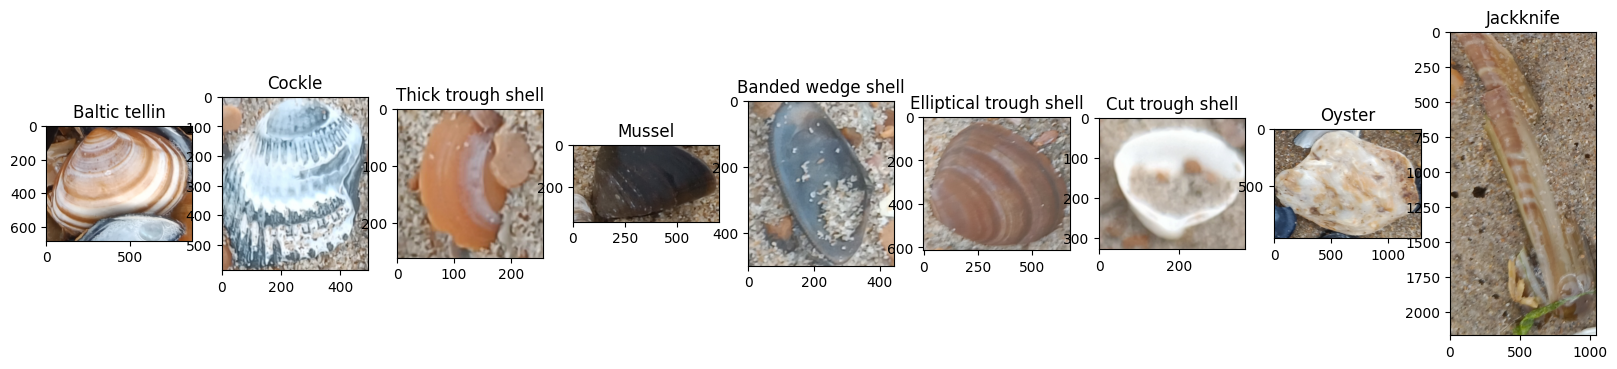

In [34]:
support_images_cutouts = orig_imgs.copy()

if remove_bg and (mode == USE_PICKED_IMAGE or mode == USE_RANDOM_IMAGE):
    # loop over all support images and remove background
    for class_name, img in support_images_cutouts.items():
        print(f"removing background from {class_name}")
        img_copy = img.copy()
        img_copy = remove(img_copy, bgcolor=(0, 0, 0, 0)).convert("RGB")
        support_images_cutouts[class_name] = img_copy
        
if mode == USE_PICKED_IMAGE or mode == USE_RANDOM_IMAGE:
    # show original images
    plt.figure(figsize=(20, 20))
    for i, (class_name, img) in enumerate(orig_imgs.items()):
        plt.subplot(1, len(orig_imgs), i + 1)
        plt.title(class_name)
        plt.imshow(img)
        print(img)
    if remove_bg:
        # show cutout images
        plt.figure(figsize=(20, 20))
        for i, (class_name, img) in enumerate(support_images_cutouts.items()):
            plt.subplot(1, len(support_images_cutouts), i + 1)
            plt.title(class_name)
            plt.imshow(img)
            print(img)
    
print(support_images_cutouts)
print(orig_imgs)

In [35]:
model = model.to(device)
model.eval()

outputs_list = []

for q in range(len(query_images)):
    print(f"Query image {q}")
    vals = list(orig_imgs.values())

    test_image_annotated = query_images[q]

    test_image = test_image_annotated.image

    test_image_filename = test_image_annotated.filename

    inputs = processor(query_images=vals, images=test_image, return_tensors="pt").to(device)
    for key, val in inputs.items():
        print(f"{key}: {val.shape}")
    
    with torch.no_grad():
        outputs = model.image_guided_detection(**inputs)
    outputs.logits = outputs.logits.cpu()
    outputs.target_pred_boxes = outputs.target_pred_boxes.cpu()
    outputs.pred_boxes = outputs.target_pred_boxes.cpu()
    outputs_list.append(outputs)

Query image 0
query_pixel_values: torch.Size([9, 3, 768, 768])
pixel_values: torch.Size([1, 3, 768, 768])
Query image 1
query_pixel_values: torch.Size([9, 3, 768, 768])
pixel_values: torch.Size([1, 3, 768, 768])
Query image 2
query_pixel_values: torch.Size([9, 3, 768, 768])
pixel_values: torch.Size([1, 3, 768, 768])
Query image 3
query_pixel_values: torch.Size([9, 3, 768, 768])
pixel_values: torch.Size([1, 3, 768, 768])
Query image 4
query_pixel_values: torch.Size([9, 3, 768, 768])
pixel_values: torch.Size([1, 3, 768, 768])
Query image 5
query_pixel_values: torch.Size([9, 3, 768, 768])
pixel_values: torch.Size([1, 3, 768, 768])
Query image 6
query_pixel_values: torch.Size([9, 3, 768, 768])
pixel_values: torch.Size([1, 3, 768, 768])
Query image 7
query_pixel_values: torch.Size([9, 3, 768, 768])
pixel_values: torch.Size([1, 3, 768, 768])
Query image 8
query_pixel_values: torch.Size([9, 3, 768, 768])
pixel_values: torch.Size([1, 3, 768, 768])
Query image 9
query_pixel_values: torch.Size([

In [36]:
visual = False
stats = True
verbose = 2


do_nmss = [True, False]
iou_thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
score_thresholds = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
filter_too_big_options = [True, False]

resultfile = open("results.csv", "w")
resultfile.write("do_nms,iou_threshold,score_threshold,filter_too_big,correct,correct_box,incorrect,undetected\n")

options_matrix = list(itertools.product(do_nmss, iou_thresholds, score_thresholds, filter_too_big_options))
print(f"Total number of options: {len(options_matrix)}")

"""
for do_nms, iou_threshold, score_threshold, filter_too_big in options_matrix:
    correctnesses:list[tuple[int, int, int]] = []
    for q in range(len(query_images)):
        test_image_annotated = query_images[q]
        test_image = test_image_annotated.image
        outputs = outputs_list[q]

        target_sizes = torch.Tensor([test_image.size[::-1]] * len(vals))
        results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold = score_threshold)
        boxes, scores, labels = results[0]["boxes"], results[0]["scores"], results[0]["labels"]

        for i in range(1, len(support_images_cutouts.keys())):
            im_boxes, im_scores, im_labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]
            boxes = torch.cat((boxes, im_boxes), dim=0)
            scores = torch.cat((scores, im_scores), dim=0)
            # add offset i to labels
            im_labels = im_labels + i
            labels = torch.cat((labels, im_labels), dim=0)
        
        if filter_too_big:
            # filter out boxes that have a height or width larger than the largest annotated box
            max_box_size = max([max([a.boxwidth, a.boxheight]) for a in test_image_annotated.annotations])
            keep = []
            for i, box in enumerate(boxes):
                if max(box[2]-box[0], box[3]-box[1]) < max_box_size:
                    keep.append(i)
            boxes = boxes[keep]
            scores = scores[keep]
            labels = labels[keep]

        # non-maximum suppression with torchvision
        if do_nms:
            keep = torchvision.ops.nms(boxes, scores, iou_threshold=iou_threshold)
            boxes = boxes[keep]
            scores = scores[keep]
            labels = labels[keep]

        if stats:
            correct = 0
            wrong_class = 0
            wrong = 0
            for box, score, label in zip(boxes, scores, labels):
                box = [round(i, 2) for i in box.tolist()]
                if(verbose > 3): print(f"Detected {list(support_images_cutouts.keys())[label]} with confidence {round(score.item(), 3)} at location {box}")
                # check if box is in the annotated image (x;y;w;h;name)
                correctness = test_image_annotated.check_bbox(box[0], box[1], box[2]-box[0], box[3]-box[1], list(support_images_cutouts.keys())[label])
                if correctness == CORRECT:
                    if(verbose > 3): print("Correct!")
                    correct += 1
                elif correctness == NAME_DOES_NOT_MATCH:
                    if(verbose > 3): print("Name does not match!")
                    wrong_class += 1
                elif correctness == NO_MATCH:
                    if(verbose > 3): print("No match!")
                    wrong += 1
                else:
                    raise Exception("Unknown correctness value")
            if(verbose>2): print(f"Correct: {correct}, Wrong class: {wrong_class}, Wrong: {wrong}")
            correctnesses.append((correct, wrong_class, wrong))

        
        if visual:
            # draw bounding boxes on image
            image = test_image.copy()
            draw = ImageDraw.Draw(image)
            for box, score, label in zip(boxes, scores, labels):
                box = [round(i, 2) for i in box.tolist()]
                draw.rectangle(box, outline="red", width=10)
                #add label and score
                draw.text((box[0]+10, box[1]+10), f"{list(support_images_cutouts.keys())[label]} {round(score.item(), 3)}", fill="red", font=ImageFont.truetype("arial", 120))

            image.save(f"out/{'Filtered' if filter_too_big else 'Unfiltered'}/{q}.jpg")
    if(stats):
        resultfile.write(f"{do_nms},{iou_threshold},{score_threshold},{filter_too_big},{sum([c[0] for c in correctnesses])},{sum([c[1] for c in correctnesses])},{sum([c[2] for c in correctnesses])}\n")
        print(f"Filter too big: {filter_too_big}")
        print(f"IOU threshold: {iou_threshold}")
        print(f"Score threshold: {score_threshold}")
        print(f"Correct: {sum([c[0] for c in correctnesses])}, Wrong class: {sum([c[1] for c in correctnesses])}, Wrong: {sum([c[2] for c in correctnesses])}")
        print(f"Accuracy: {round(100 * sum([c[0] for c in correctnesses])/sum([sum(c) for c in correctnesses]), 3)}%")
        print(f"Accuracy (correct bbox): {round(100 * (sum([c[0] for c in correctnesses])+sum([c[1] for c in correctnesses]))/sum([sum(c) for c in correctnesses]), 3)}%")
"""

def process_options(do_nms, iou_threshold, score_threshold, filter_too_big) -> tuple[int, int, int, int]:
    correct = 0
    wrong_class = 0
    wrong = 0
    undetected = 0
    for q in range(len(query_images)):
        test_image_annotated = query_images[q]
        test_image = test_image_annotated.image
        outputs = outputs_list[q]

        target_sizes = torch.Tensor([test_image.size[::-1]] * len(vals))
        results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold = score_threshold)
        boxes, scores, labels = results[0]["boxes"], results[0]["scores"], results[0]["labels"]

        for i in range(1, len(support_images_cutouts.keys())):
            im_boxes, im_scores, im_labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]
            boxes = torch.cat((boxes, im_boxes), dim=0)
            scores = torch.cat((scores, im_scores), dim=0)
            # add offset i to labels
            im_labels = im_labels + i
            labels = torch.cat((labels, im_labels), dim=0)
        
        if filter_too_big:
            # filter out boxes that have a height or width larger than the largest annotated box
            max_box_size = max([max([a.boxwidth, a.boxheight]) for a in test_image_annotated.annotations])
            keep = []
            for i, box in enumerate(boxes):
                if max(box[2]-box[0], box[3]-box[1]) < max_box_size:
                    keep.append(i)
            boxes = boxes[keep]
            scores = scores[keep]
            labels = labels[keep]

        # non-maximum suppression with torchvision
        if do_nms:
            keep = torchvision.ops.nms(boxes, scores, iou_threshold=iou_threshold)
            boxes = boxes[keep]
            scores = scores[keep]
            labels = labels[keep]

        boxes_in_image = set()
        for box, score, label in zip(boxes, scores, labels):
            box = [round(i, 2) for i in box.tolist()]
            if(verbose > 3): print(f"Detected {list(support_images_cutouts.keys())[label]} with confidence {round(score.item(), 3)} at location {box}")
            # check if box is in the annotated image (x;y;w;h;name)
            correctness, box = test_image_annotated.check_bbox(box[0], box[1], box[2]-box[0], box[3]-box[1], list(support_images_cutouts.keys())[label])
            boxes_in_image.add(box)
            if correctness == CORRECT:
                if(verbose > 3): print("Correct!")
                # correct aka true positive
                correct += 1
            elif correctness == NAME_DOES_NOT_MATCH:
                if(verbose > 3): print("Name does not match!")
                # wrong class is false positive
                wrong_class += 1
            elif correctness == NO_MATCH:
                if(verbose > 3): print("No match!")
                # wrong is false positive
                wrong += 1
            else:
                raise Exception("Unknown correctness value")
        # check if all annotated boxes are in the detected boxes
        for annotation in test_image_annotated.annotations:
            if annotation not in boxes_in_image:
                if(verbose > 3): print(f"Annotation {annotation} not found!")
                # wrong is false negative
                undetected += 1
        if(verbose>2): print(f"Correct: {correct}, Wrong class: {wrong_class}, Wrong: {wrong}")
    return(correct, wrong_class, wrong, undetected)



for do_nms, iou_threshold, score_threshold, filter_too_big in options_matrix:
    correctnesses:list[tuple[int, int, int, int]] = []
    correctness = process_options(do_nms, iou_threshold, score_threshold, filter_too_big)
    correctnesses.append(correctness)
            
    if(stats):
        resultfile.write(f"{do_nms},{iou_threshold},{score_threshold},{filter_too_big},{sum([c[0] for c in correctnesses])},{sum([c[1] for c in correctnesses])},{sum([c[2] for c in correctnesses])},{sum([c[3] for c in correctnesses])}\n")
        print(f"Filter too big: {filter_too_big}")
        print(f"IOU threshold: {iou_threshold}")
        print(f"Score threshold: {score_threshold}")
        print(f"Correct: {sum([c[0] for c in correctnesses])}, Wrong class: {sum([c[1] for c in correctnesses])}, Wrong: {sum([c[2] for c in correctnesses])}")
        print(f"Accuracy: {round(100 * sum([c[0] for c in correctnesses])/sum([sum(c) for c in correctnesses]), 3)}%")
        print(f"Accuracy (correct bbox): {round(100 * (sum([c[0] for c in correctnesses])+sum([c[1] for c in correctnesses]))/sum([sum(c) for c in correctnesses]), 3)}%")

resultfile.close()

Total number of options: 288
Filter too big: True
IOU threshold: 0.1
Score threshold: 0.01
Correct: 19, Wrong class: 321, Wrong: 14719
Accuracy: 0.125%
Accuracy (correct bbox): 2.229%
Filter too big: False
IOU threshold: 0.1
Score threshold: 0.01
Correct: 14, Wrong class: 289, Wrong: 16554
Accuracy: 0.082%
Accuracy (correct bbox): 1.773%
Filter too big: True
IOU threshold: 0.1
Score threshold: 0.02
Correct: 16, Wrong class: 289, Wrong: 11425
Accuracy: 0.134%
Accuracy (correct bbox): 2.55%
Filter too big: False
IOU threshold: 0.1
Score threshold: 0.02
Correct: 10, Wrong class: 259, Wrong: 12967
Accuracy: 0.074%
Accuracy (correct bbox): 1.993%
Filter too big: True
IOU threshold: 0.1
Score threshold: 0.05
Correct: 7, Wrong class: 200, Wrong: 4799
Accuracy: 0.131%
Accuracy (correct bbox): 3.887%
Filter too big: False
IOU threshold: 0.1
Score threshold: 0.05
Correct: 4, Wrong class: 178, Wrong: 6027
Accuracy: 0.061%
Accuracy (correct bbox): 2.777%
Filter too big: True
IOU threshold: 0.1
Sco

     do_nms  iou_threshold  score_threshold  filter_too_big  correct_box  \
264   False            0.8              0.2            True          381   
280   False            0.9              0.2            True          381   
248   False            0.7              0.2            True          381   
216   False            0.5              0.2            True          381   
200   False            0.4              0.2            True          381   

     true positive  false positive  false negative  Accuracy  \
264             44            1016             421     2.971   
280             44            1016             421     2.971   
248             44            1016             421     2.971   
216             44            1016             421     2.971   
200             44            1016             421     2.971   

     Accuracy (correct bbox)  Precision  Recall    F1  
264                   28.697      4.151   9.462  5.77  
280                   28.697      4.151   9.46

<AxesSubplot:title={'center':'Precision'}, xlabel='[filter_too_big]'>

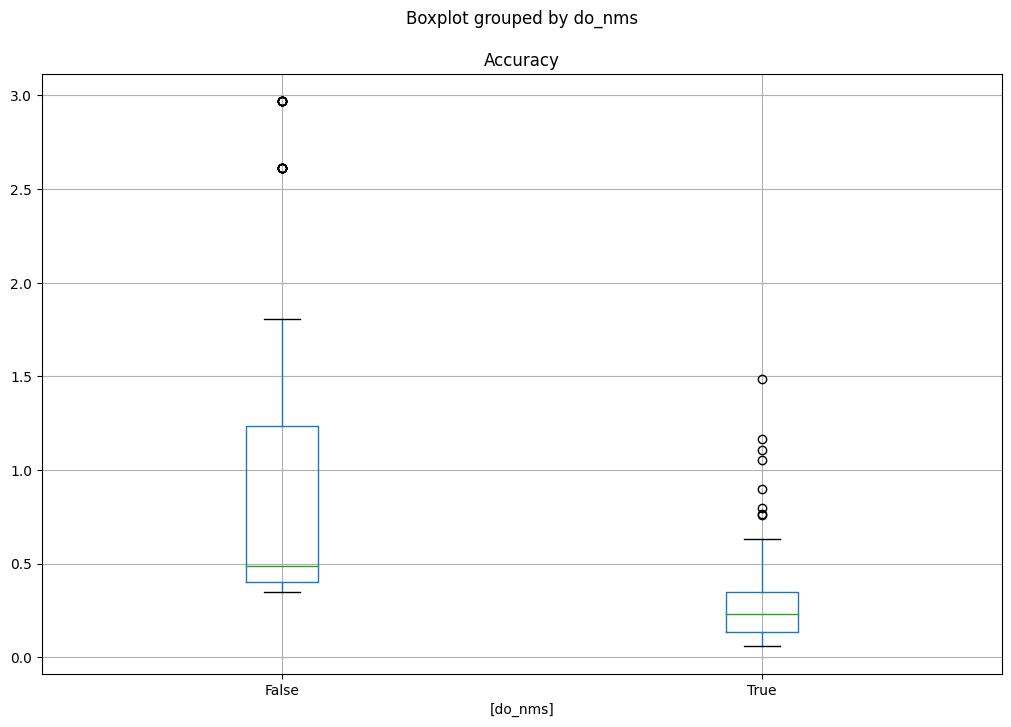

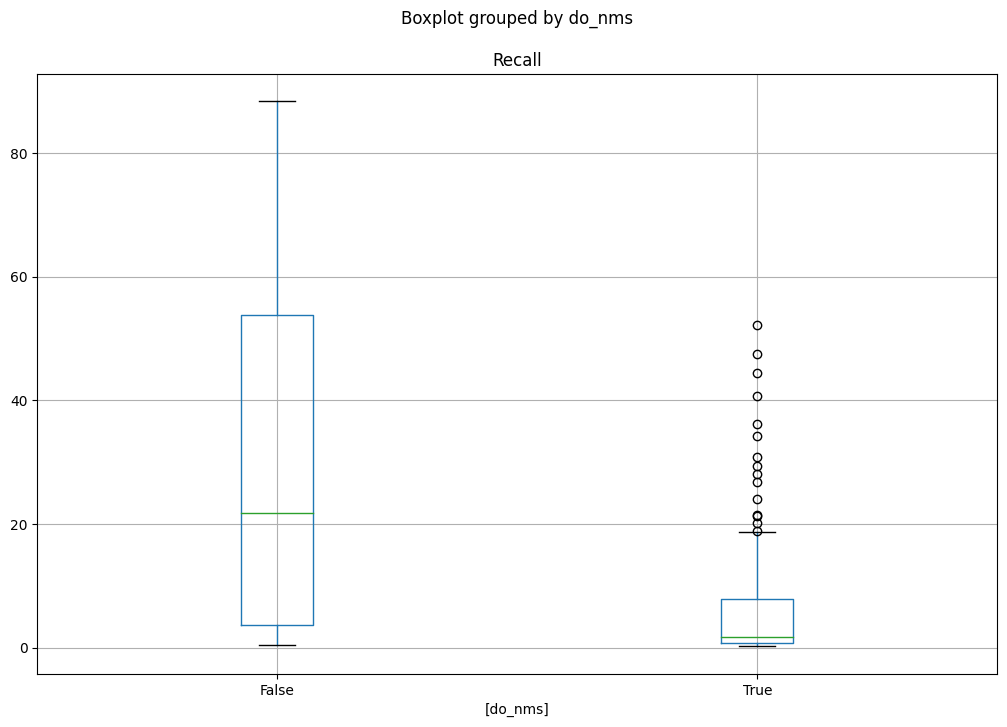

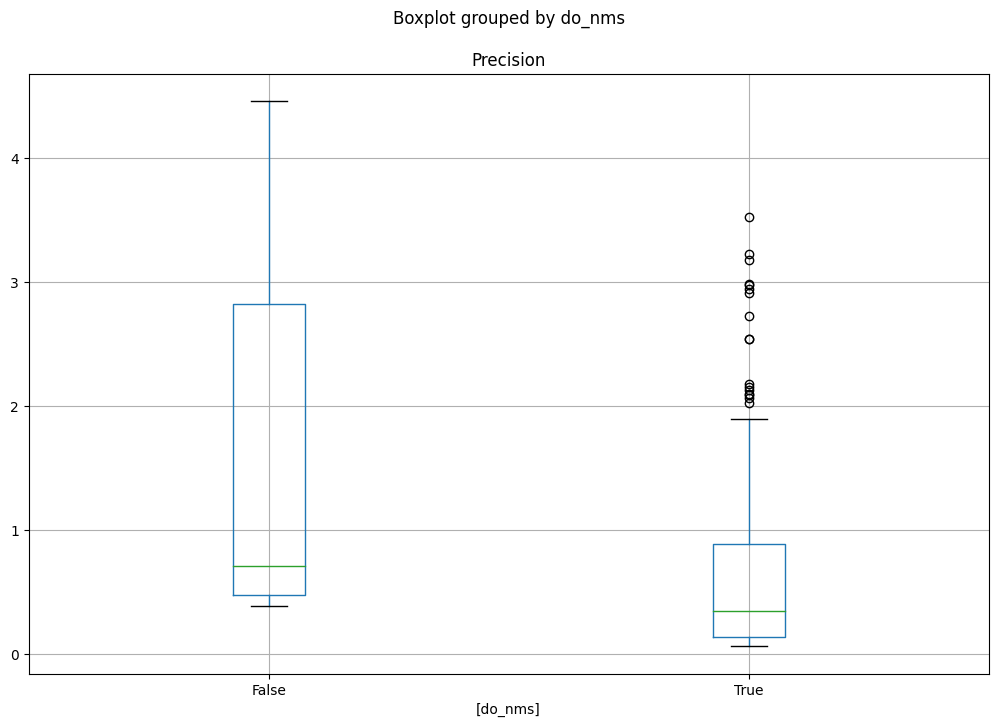

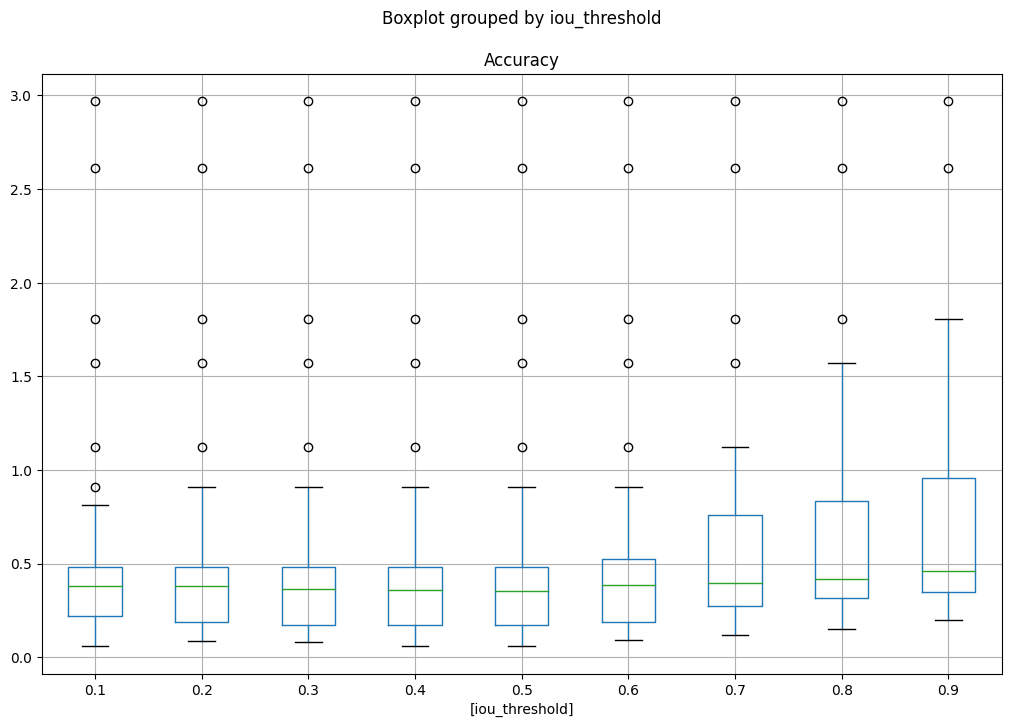

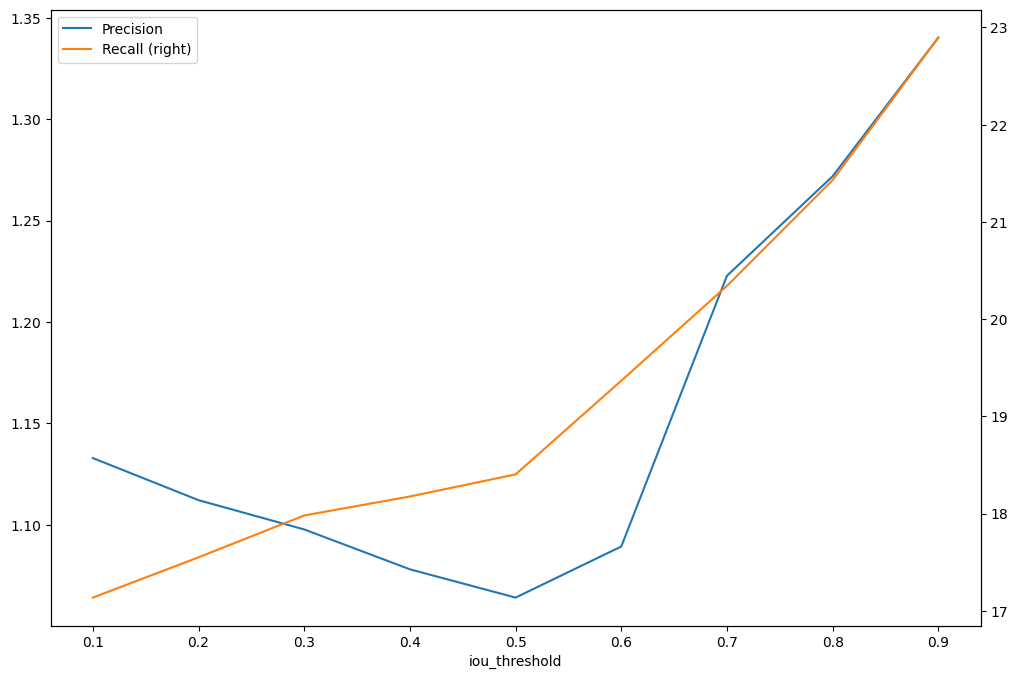

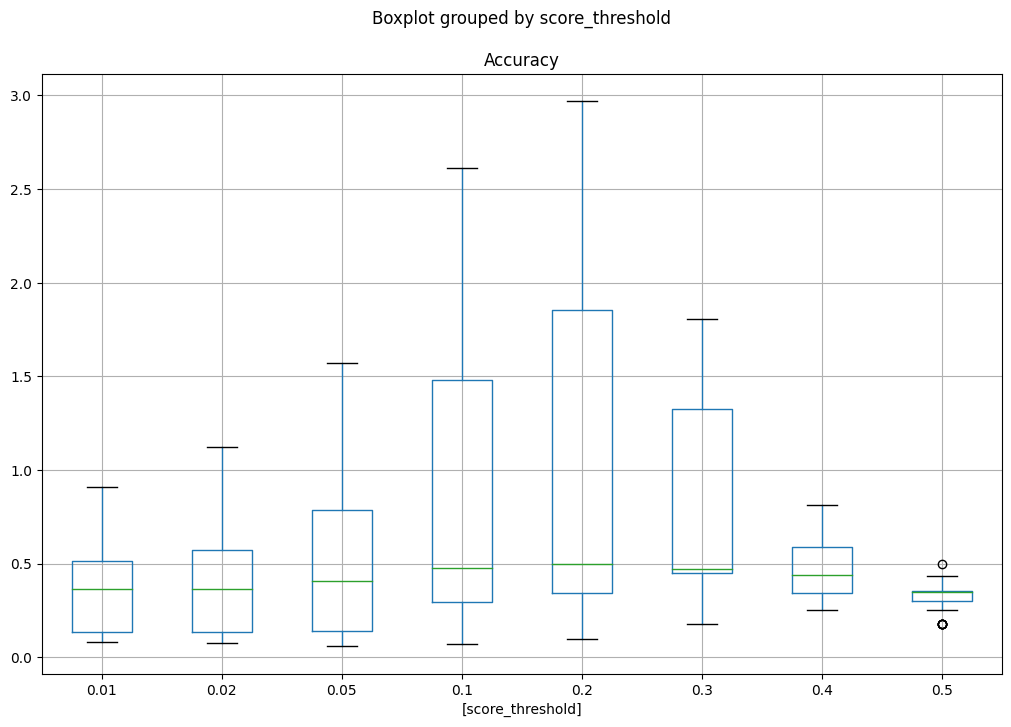

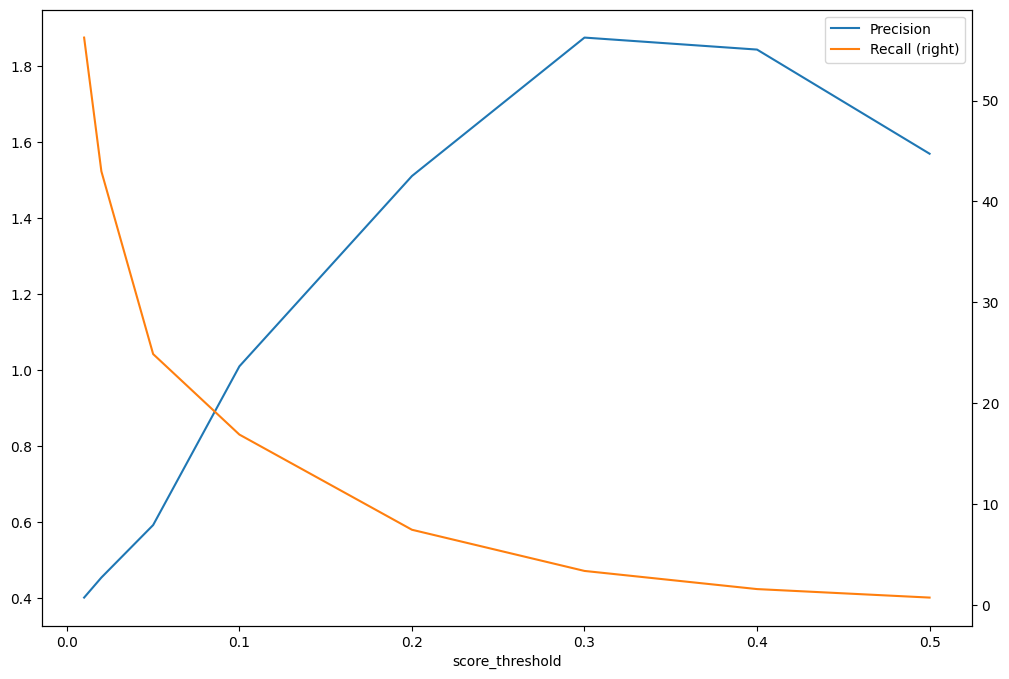

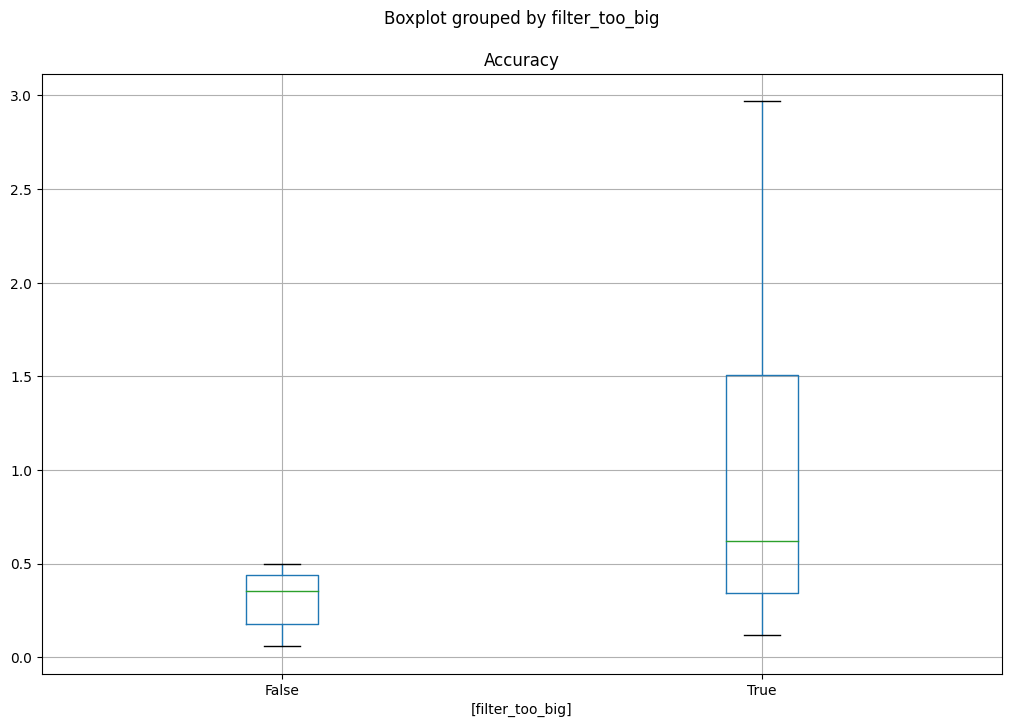

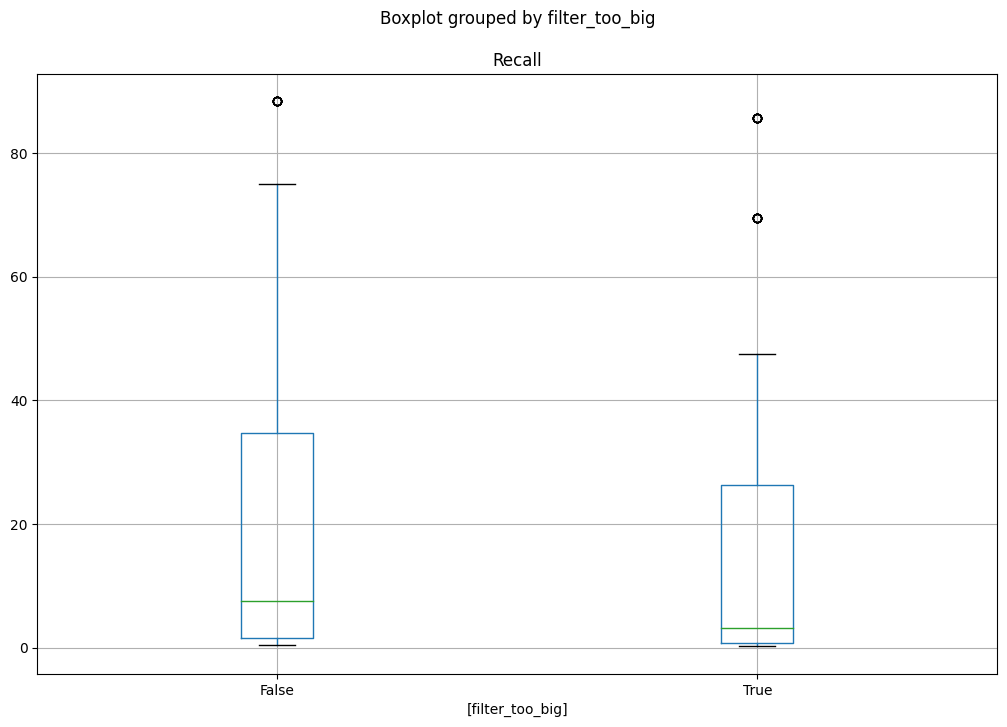

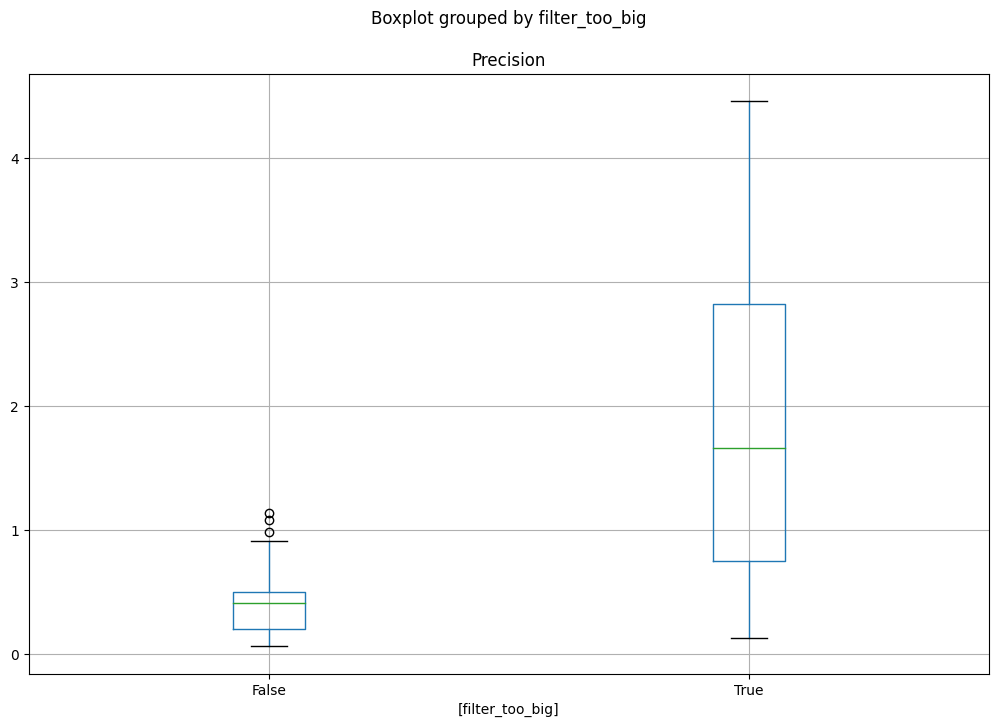

In [69]:
df = pd.read_csv("results.csv")
df.head()

df["true positive"] = df["correct"]
df["false positive"] = df["incorrect"] + df["correct_box"]
df["false negative"] = df["undetected"]
# remove correct, incorrect, correct_box, undetected
df.drop(columns=["correct", "incorrect", "undetected"], inplace=True)
df["Accuracy"] = round(100 * df["true positive"]/(df["true positive"] + df["false positive"] + df["false negative"]), 3)
df["Accuracy (correct bbox)"] = round(100 * (df["true positive"] + df["correct_box"])/(df["true positive"] + df["false positive"] + df["false negative"]), 3)
df["Precision"] = round(100 * (df["true positive"]/(df["true positive"] + df["false positive"])), 3)
df["Recall"] = round(100 * (df["true positive"]/(df["true positive"] + df["false negative"])), 3)
df["F1"] = round(2 * df["Precision"] * df["Recall"]/(df["Precision"] + df["Recall"]), 3)

# sort by accuracy
df.sort_values(by=["Accuracy"], ascending=False, inplace=True)
print(df.head())

df.to_csv("results_processed.csv", index=False)

# boxplot of accuracy with nms True vs False
df.boxplot(column=["Accuracy"], by=["do_nms"], figsize=(12, 8))

# boxplot of recall with nms True vs False
df.boxplot(column=["Recall"], by=["do_nms"], figsize=(12, 8))

# boxplot of precision with nms True vs False
df.boxplot(column=["Precision"], by=["do_nms"], figsize=(12, 8))

# boxplot of iou_threshold
df.boxplot(column=["Accuracy"], by=["iou_threshold"], figsize=(12, 8))

# precision and recall with different iou_thresholds in a line plot on two axes
df.groupby(["iou_threshold"]).mean().plot(y=["Precision", "Recall"], figsize=(12, 8), secondary_y="Recall")

# boxplot of score_threshold
df.boxplot(column=["Accuracy"], by=["score_threshold"], figsize=(12, 8))

# precision and recall with different score_thresholds in a line plot on two axes
df.groupby(["score_threshold"]).mean().plot(y=["Precision", "Recall"], figsize=(12, 8), secondary_y="Recall")

# boxplot of accuracy with filter_too_big True vs False
df.boxplot(column=["Accuracy"], by=["filter_too_big"], figsize=(12, 8))

# boxplot of recall with filter_too_big True vs False
df.boxplot(column=["Recall"], by=["filter_too_big"], figsize=(12, 8))

# boxplot of precision with filter_too_big True vs False
df.boxplot(column=["Precision"], by=["filter_too_big"], figsize=(12, 8))











In [68]:
# sort by recall
df.sort_values(by=["Recall"], ascending=False, inplace=True)
print(df.head())

     do_nms  iou_threshold  score_threshold  filter_too_big  correct_box  \
257   False            0.8             0.01           False         5122   
161   False            0.2             0.01           False         5122   
209   False            0.5             0.01           False         5122   
193   False            0.4             0.01           False         5122   
225   False            0.6             0.01           False         5122   

     true positive  false positive  false negative  Accuracy  \
257            679          176016              89     0.384   
161            679          176016              89     0.384   
209            679          176016              89     0.384   
193            679          176016              89     0.384   
225            679          176016              89     0.384   

     Accuracy (correct bbox)  Precision  Recall     F1  
257                    3.281      0.384  88.411  0.765  
161                    3.281      0.384  88.